# Python Sandbox


## Setup

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import sys
from pathlib import Path
from typing import Iterable

import pandas as pd
import rpy2.robjects as ro
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

In [4]:
from components.functional_analysis.orgdb import OrgDB
from r_wrappers.deseq2 import vst_transform
from r_wrappers.utils import pd_df_to_rpy2_df, rpy2_df_to_pd_df

### Global Variables

In [5]:
TCGA_PRAD_SU2C_PCF_GSE221601_ROOT: Path = Path(
    "/media/ssd/Perez/storage/TCGA_PRAD_SU2C_PCF_GSE221601"
)
GOIS: Iterable[str] = ("TPX2", "EZH2", "TROAP", "COX1", "UHRF1")
ORG_DB: OrgDB = OrgDB("Homo sapiens")

## Sandbox

### For all integrative analysis results, find appereances of genes of interest.

### Copy original tar counts files to analysis directory

In [6]:
STAR_ROOT: Path = Path("/rawdata/GSE221601/mapping/star")
ANALYSIS_ROOT: Path = Path("/media/ssd/Perez/storage/GSE221601/data")
STAR_ORIGINAL_COUNTS_PATH: Path = ANALYSIS_ROOT / "star_original_counts"
STAR_ORIGINAL_COUNTS_PATH.mkdir(exist_ok=True, parents=True)
STAR_UNSTRANDED_COUNTS_PATH: Path = ANALYSIS_ROOT / "star_unstranded_counts"
STAR_UNSTRANDED_COUNTS_PATH.mkdir(exist_ok=True, parents=True)
STAR_FIRST_READ_STRAND_COUNTS_PATH: Path = (
    ANALYSIS_ROOT / "star_first_read_strand_counts"
)
STAR_FIRST_READ_STRAND_COUNTS_PATH.mkdir(exist_ok=True, parents=True)
STAR_SECOND_READ_STRAND_COUNTS_PATH: Path = (
    ANALYSIS_ROOT / "star_second_read_strand_counts"
)
STAR_SECOND_READ_STRAND_COUNTS_PATH.mkdir(exist_ok=True, parents=True)

In [7]:
for tab_file in STAR_ROOT.rglob("ReadsPerGene.out.tab"):
    parent_dir_name = tab_file.parent.name
    destination_file = STAR_ORIGINAL_COUNTS_PATH / f"{parent_dir_name}.tab"
    destination_file.write_bytes(tab_file.read_bytes())

### Annotate LRT deseq files

In [8]:
lrt_files = list(
    Path("/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_LRT/deseq2").glob(
        "*deseq_results.csv"
    )
)
for lrt_file in lrt_files:
    print(lrt_file)

/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_LRT/deseq2/res_LRT_across_sample_types_overall_effects_hspc+mcrpc+norm+prim_1232samples_deseq_results.csv
/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_LRT/deseq2/res_LRT_across_sample_types_overall_effects_hspc+mcrpc+norm+prim_1232samples_padj_0_05_all_1_0_deseq_results.csv
/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_LRT/deseq2/res_LRT_across_sample_types_overall_effects_hspc+mcrpc+norm+prim_1232samples_padj_0_05_down_1_0_deseq_results.csv
/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_LRT/deseq2/res_LRT_across_sample_types_overall_effects_hspc+mcrpc+norm+prim_1232samples_padj_0_05_up_1_0_deseq_results.csv


### Batch Correction PCA figures

In [9]:
counts_files = [
    "raw_counts.csv",
    "all_counts_batch_corrected_v1.csv",
    "all_counts_batch_corrected_v2.csv",
    "all_counts_batch_corrected_v3.csv",
]
root_path = Path("/media/ssd/Perez/storage/PCTA_WCDT_GSE221601/data")
manuscript_figures_path = root_path.parent / "manuscript_figures"
manuscript_figures_path.mkdir(exist_ok=True, parents=True)
CONTRASTS_LEVELS_COLORS = {
    "mcrpc": "#8B3A3A",
    "prim": "#4A708B",
    "hspc": "#8B008B",
    "norm": "#9ACD32",
}
annot_df = pd.read_csv(root_path / "samples_annotation.csv", index_col=0)

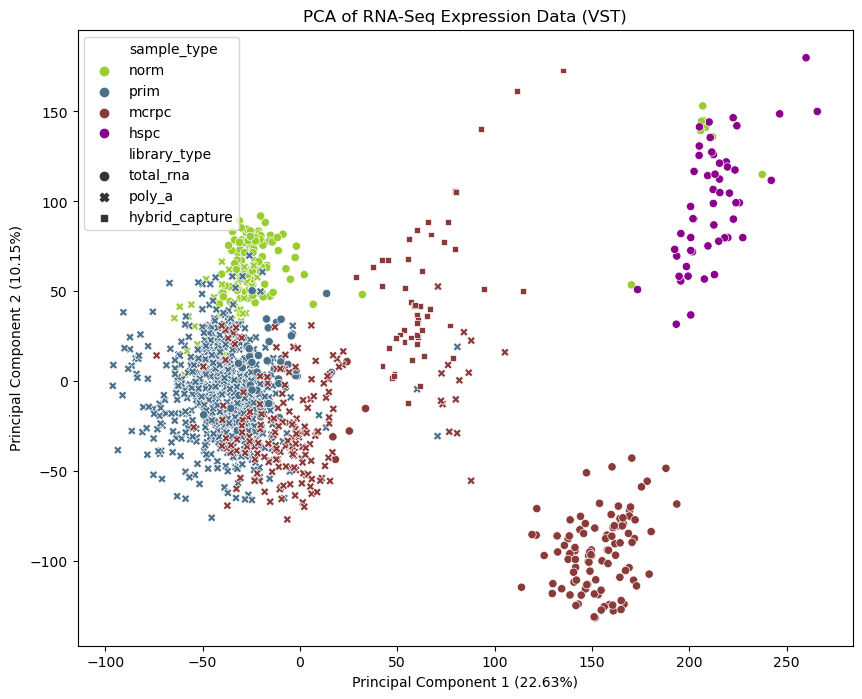

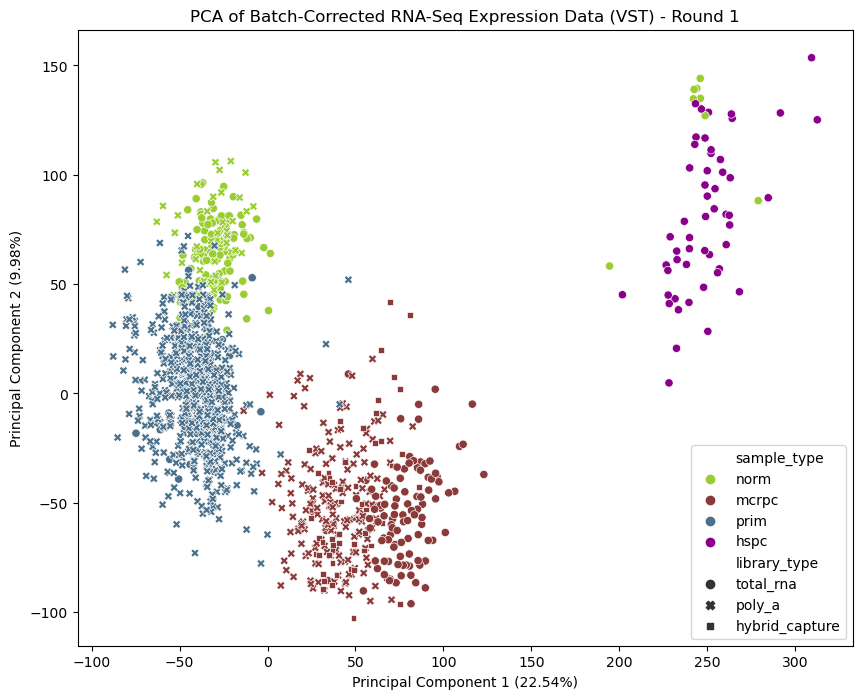

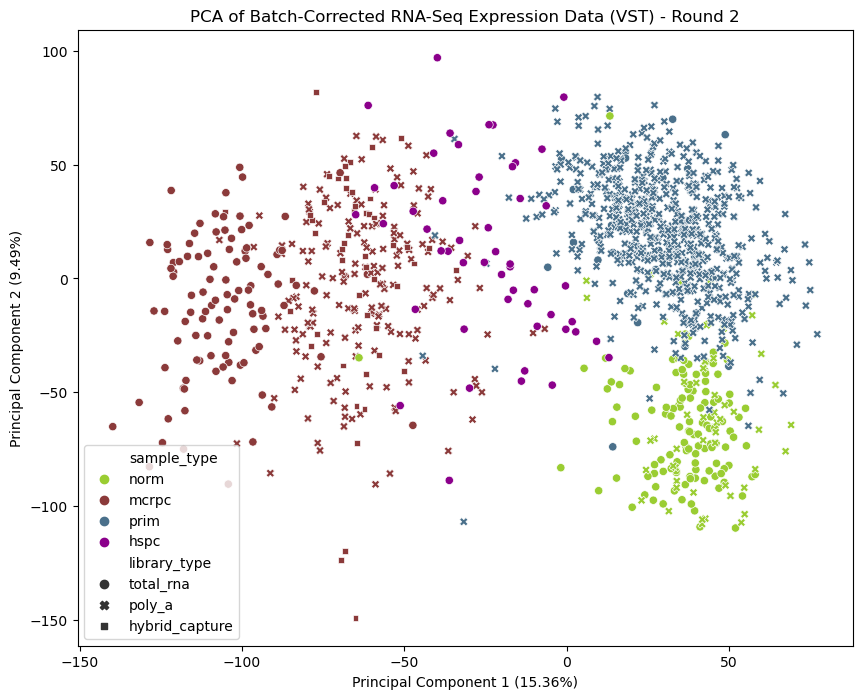

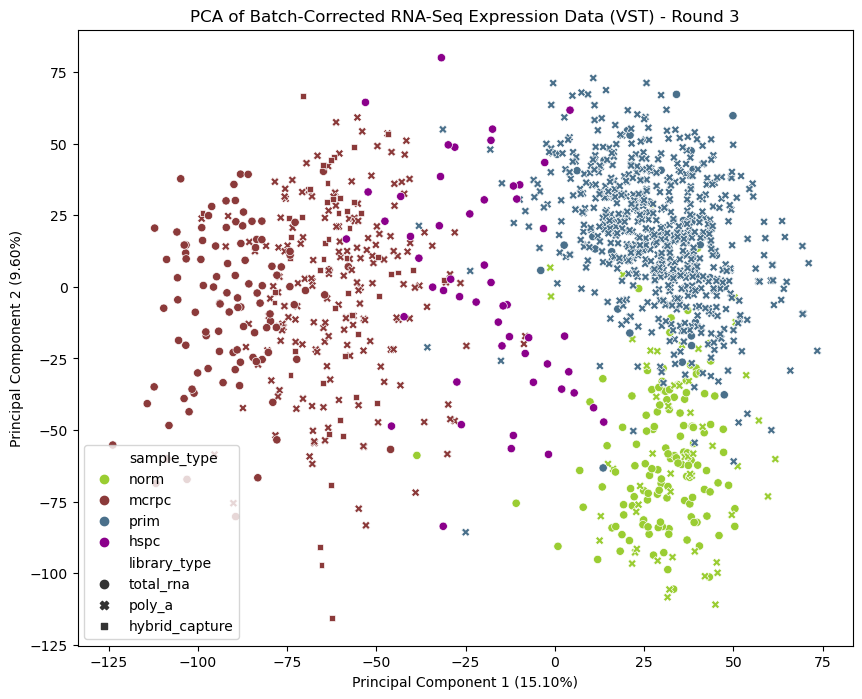

In [10]:
for i, count_file in enumerate(counts_files):
    counts_df = pd.read_csv(root_path / count_file, index_col=0)
    vst_df = rpy2_df_to_pd_df(
        vst_transform(ro.r("as.matrix")(pd_df_to_rpy2_df(counts_df)))
    )

    pca_corrected = PCA(n_components=2)
    pca_result_corrected = pca_corrected.fit_transform(vst_df.T)

    pca_df_corrected = pd.DataFrame(
        data=pca_result_corrected,
        columns=["PC1", "PC2"],
        index=vst_df.columns,
    )
    pca_df_corrected["sample_type"] = annot_df.loc[vst_df.columns, "sample_type"].values
    pca_df_corrected["dataset"] = annot_df.loc[vst_df.columns, "dataset"].values
    pca_df_corrected["library_type"] = annot_df.loc[
        vst_df.columns, "library_type"
    ].values
    explained_variance = pca_corrected.explained_variance_ratio_

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="PC1",
        y="PC2",
        hue="sample_type",
        style="library_type",
        data=pca_df_corrected,
        palette=CONTRASTS_LEVELS_COLORS,
    )
    if i == 0:
        plt.title("PCA of RNA-Seq Expression Data (VST)")
    else:
        plt.title(f"PCA of Batch-Corrected RNA-Seq Expression Data (VST) - Round {i}")
    plt.xlabel(f"Principal Component 1 ({explained_variance[0] * 100:.2f}%)")
    plt.ylabel(f"Principal Component 2 ({explained_variance[1] * 100:.2f}%)")
    plt.legend(loc="best")
    plt.savefig(manuscript_figures_path / f"{Path(count_file).stem}_pca.pdf")
    plt.show()